# Working with data 2017. Class 3
## Contact
Javier Garcia-Bernardo
garcia@uva.nl

## 0. Structure
1. Error debugging
2. Data visualization theory
    - Scatter
    - Histograms, violinplots and two histograms (jointplot)
    - Line plots with distributions (factorplot)
    - Paralell coordinates    
3. Dealing with missing data
4. In-class exercises to melt, pivot, concat and merge
5. Groupby and in-class exercises
7. Stats
    - What's a p-value?
    - One-tailed test vs two-tailed test
    - Count vs expected count (binomial test)
    - Independence between factors: ($\chi^2$ test)      

In [23]:
##Some code to run at the beginning of the file, to be able to show images in the notebook
##Don't worry about this cell

#Print the plots in this screen
%matplotlib inline 

#Be able to plot images saved in the hard drive
from IPython.display import Image 

#Make the notebook wider
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))

import seaborn as sns
import pylab as plt
import pandas as pd
import numpy as np

def read_our_csv():
    #reading the raw data from oecd
    df = pd.read_csv("../class2/data/CITIES_19122016195113034.csv",sep="\t")

    #fixing the columns (the first one is ""METRO_ID"" instead of "METRO_ID")
    cols = list(df.columns)
    cols[0] = "METRO_ID"
    df.columns = cols
    
    #pivot the table
    column_with_values = "Value"
    column_to_split = ["VAR"]
    variables_already_present = ["METRO_ID","Metropolitan areas","Year"]
    df_fixed = df.pivot_table(column_with_values,
                 variables_already_present,
                 column_to_split).reset_index()
    
    return df_fixed
    

## 3. Dealing with missing data
Let's imagine we have a data of a survey, with age, income, education, political ideas, location, and if you will vote for Trump or Hillary.

We may have some missing values. This missing values can be:
- MCAR (missing completely at random), which means that we have a representative sample. 
    - This for example could happen if during the survey collection there were some IT problems.
    - It is a strong assumption but it is usually made.
    - If the data is MCAR we can either ignore the rows with missing values and still have a representative sample.
    - If we have some missing data in a survey: Imagine if young voters of Trump are less likely to answer --> Then your data is MAR.
    - Usually in surveys you make sure you ask to a percentage of people of age and location that correspond with the real population. But you may be missing an important variable (for example US pollsters didn't ask to a representative sample in terms of education). 



- MAR (missing at random), which means that we don't have a representative sample, but we can use another column to `impute` missing values. 
    - This is very common.
    - We can correct the data by using other people that did answer. For instance, two people living in the same area, with the same age, income, education and political ideas are likely to vote similar, so if you only know how one of them intends to vote you can say that the other one will vote the same (there are methods for this, don't do it by hand!)



- MNAR (missing not at random), which means that we don't have a representative sample, and imputation is very very hard. This can happen for example if Trump voters are less likely to open the door, then they are not even in your sample.
    - We are in trouble and the methods to correct for this are way beyond the scope of the class.


### What are the strategies to correct for missing values?
- 3.1 Ignore those values (only if your data is MCAR)
- Impute those values (always better but more complicated)
    - 3.2 Use the mean/median/mode as the value (only works well in MCAR)
    - 3.3 Use similar values -> fancyimpute package (another time)

array([  0.,   1.,   2.,  nan,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

array([  0.,   1.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

---

In [6]:
#Read and fix the data
df_fixed = read_our_csv()

#Remove rows with missing values
cols = ["LABOUR_PRODUCTIVITY","UNEMP_R","GDP_PC"]
df_fixed = df_fixed.dropna(subset=cols)

#Creating a column for country
df_fixed["C"] = df_fixed["METRO_ID"].apply(lambda x: x[:2])

#Keeping italy
df_fixed = df_fixed.loc[df_fixed["C"]=="IT",["C","METRO_ID","Metropolitan areas"] +cols]

#We are going to normalize values dividing by the mean (so new values have a mean of 1)
df_fixed.loc[:,cols] = df_fixed[cols]/np.nanmean(df_fixed[cols],0)

#Make a copy of the data
df_original = df_fixed.copy()

#Take a random sample of 20 values of productivity
sample = set(df_fixed.loc[:,"LABOUR_PRODUCTIVITY"].sample(20))

#Deleting those values (saying that they are np.NaN (missing))
df_fixed.loc[df_fixed["LABOUR_PRODUCTIVITY"].isin(sample),"LABOUR_PRODUCTIVITY"] = np.NaN
df_fixed.head(10)

VAR,C,METRO_ID,Metropolitan areas,LABOUR_PRODUCTIVITY,UNEMP_R,GDP_PC
1530,IT,IT001,Rome,1.246225,1.153054,1.263583
1531,IT,IT001,Rome,1.263464,1.041401,1.292440
1532,IT,IT001,Rome,1.244960,0.827486,1.302868
1533,IT,IT001,Rome,1.227114,0.837920,1.285412
1534,IT,IT001,Rome,1.241025,0.779485,1.325299
1535,IT,IT001,Rome,1.249625,0.766963,1.330681
1536,IT,IT001,Rome,NaN,0.752354,1.350295
1537,IT,IT001,Rome,NaN,0.613571,1.366838
1538,IT,IT001,Rome,1.227992,0.734615,1.340511
1539,IT,IT001,Rome,1.194594,0.840007,1.292339


### 3.1 Ignoring data

In [7]:
#How to fix by ignoring the rows
ignoring = df_fixed.dropna(subset=["LABOUR_PRODUCTIVITY"])
ignoring.head(10)

VAR,C,METRO_ID,Metropolitan areas,LABOUR_PRODUCTIVITY,UNEMP_R,GDP_PC
1530,IT,IT001,Rome,1.246225,1.153054,1.263583
1531,IT,IT001,Rome,1.263464,1.041401,1.292440
1532,IT,IT001,Rome,1.244960,0.827486,1.302868
1533,IT,IT001,Rome,1.227114,0.837920,1.285412
1534,IT,IT001,Rome,1.241025,0.779485,1.325299
1535,IT,IT001,Rome,1.249625,0.766963,1.330681
1538,IT,IT001,Rome,1.227992,0.734615,1.340511
1539,IT,IT001,Rome,1.194594,0.840007,1.292339
1540,IT,IT001,Rome,1.183977,0.932878,1.278036
1541,IT,IT001,Rome,1.190526,0.884877,1.276332


### 3.2 Imputing with mean/median/mode

In [8]:
#How to fix by imputing with mean/median/mode
mean_inputed = df_fixed.fillna(df_fixed.mean())
mean_inputed.head(10)

VAR,C,METRO_ID,Metropolitan areas,LABOUR_PRODUCTIVITY,UNEMP_R,GDP_PC
1530,IT,IT001,Rome,1.246225,1.153054,1.263583
1531,IT,IT001,Rome,1.263464,1.041401,1.292440
1532,IT,IT001,Rome,1.244960,0.827486,1.302868
1533,IT,IT001,Rome,1.227114,0.837920,1.285412
1534,IT,IT001,Rome,1.241025,0.779485,1.325299
1535,IT,IT001,Rome,1.249625,0.766963,1.330681
1536,IT,IT001,Rome,1.000143,0.752354,1.350295
1537,IT,IT001,Rome,1.000143,0.613571,1.366838
1538,IT,IT001,Rome,1.227992,0.734615,1.340511
1539,IT,IT001,Rome,1.194594,0.840007,1.292339


### 3.3  Imputing using neighbours
- We may go over this another day, it's not an easy topic.
- But the basic idea is that you are probably similar to your neighbors (variables are correlated)
- In this case is easier because we have the neighbours (same city for other years). But let's assume we don't.

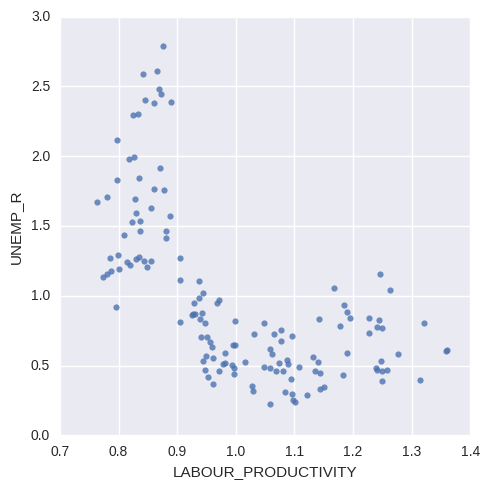

In [9]:
#Based on this. Similar points for unemployment have similar points for productivity
sns.lmplot(x="LABOUR_PRODUCTIVITY",y="UNEMP_R",data=df_fixed,fit_reg=False)

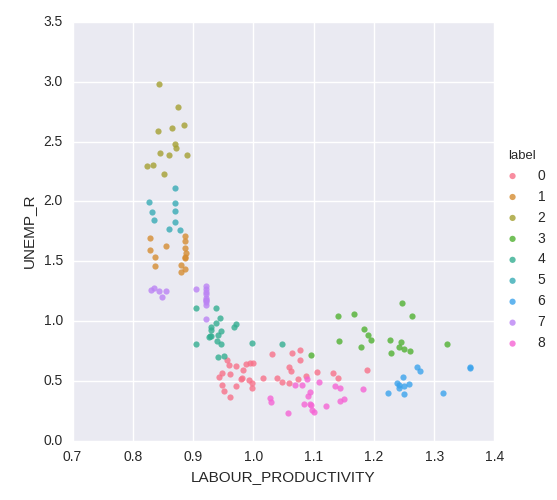

In [11]:
Image("figures/labels.png")

Using a random sample => MCAR DATA


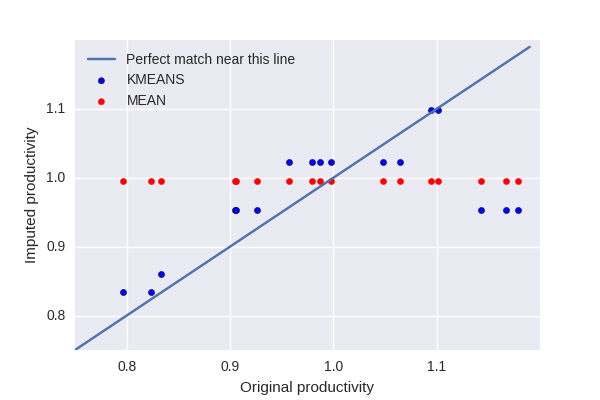

In [12]:
print("Using a random sample => MCAR DATA")
Image("figures/kmeans_vs_mean.png")

Using a biasad sample => MAR DATA


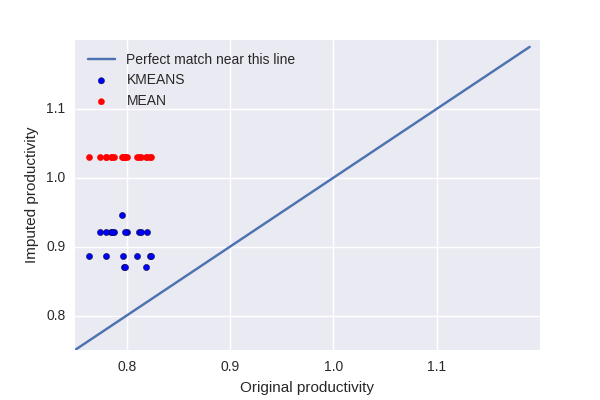

In [13]:
print("Using a biasad sample => MAR DATA")
Image("figures/kmeans_vs_mean_worst_case.png")

# 4. In-class exercises to melt, pivot, concat and merge


## 4.0 Paths
- Absolute (too long, no cross-compativility)


In [9]:
#What's our current directory
import os
os.getcwd()

'/datastore0/classroom/classes/wwd2017/class3'

In [ ]:
pd.read_stata("data/colombia.dta")

- Relative to the current directory
    - the path "class3a_groupby.ipynb" is the same than '/datastore0/classroom/classes/wwd2017/class3/class3a_groupby.ipynb'
    - the path "data/colombia.dta" is the same than '/datastore0/classroom/classes/wwd2017/class3/data/class3a_groupby.ipynb'
    - the path "../README.md" is the same than '/datastore0/classroom/classes/wwd2017/README.md'
    - the path "../class2/hw_2.ipynb" is the same than '/datastore0/classroom/classes/wwd2017/class2/hw_2.ipynb'



## 4.1 Read the data from the world bank (inside folder data, subfolder world_bank), and save it with name df


In [15]:
#Read data and print the head to see how it looks like
df = pd.read_csv("data/world_bank/data.csv",na_values="..")
df.head()

,﻿Country Name,Country Code,Series Name,Series Code,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
0,Netherlands,NLD,"Health expenditure, private (% of GDP)",SH.XPD.PRIV.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.376684,1.361519,1.388759,1.394426,1.441308,1.483926,1.427731,1.416160,NaN,NaN
1,Netherlands,NLD,"Health expenditure, public (% of GDP)",SH.XPD.PUBL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.980489,8.209741,8.901517,9.081296,9.085858,9.528422,9.617135,9.481133,NaN,NaN
2,Netherlands,NLD,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,73.804146,73.612683,73.539512,73.58561,73.809512,73.727073,...,80.097561,80.251220,80.548780,80.702439,81.204878,81.104878,81.304878,81.304878,NaN,NaN
3,Colombia,COL,"Health expenditure, private (% of GDP)",SH.XPD.PRIV.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.713840,1.921929,1.864133,1.781872,1.619624,1.655958,1.624282,1.791355,NaN,NaN
4,Colombia,COL,"Health expenditure, public (% of GDP)",SH.XPD.PUBL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.539527,4.698007,5.148274,4.975653,5.016165,5.277512,5.218918,5.409943,NaN,NaN


In [ ]:
df.columns = ["Country Name","Country Code","Series Name","Series Code",1967,1968,1969,...]

In [ ]:
df.to_csv("data/new_columns.csv",sep="\t")

In [51]:
## 4.1b Fix the year of the column (make it numbers)
df = pd.read_csv("data/world_bank/data.csv",na_values="..")
old_columns = list(df.columns)

new_columns = []

for index,column_name in enumerate(old_columns):
    if index < 4: 
        new_columns.append(column_name)
    else:
        year_column = int(column_name[:4])
        new_columns.append(year_column)

df.columns = new_columns
df.head()

,﻿Country Name,Country Code,Series Name,Series Code,1967,1968,1969,1970,1971,1972,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Netherlands,NLD,"Health expenditure, private (% of GDP)",SH.XPD.PRIV.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.376684,1.361519,1.388759,1.394426,1.441308,1.483926,1.427731,1.416160,NaN,NaN
1,Netherlands,NLD,"Health expenditure, public (% of GDP)",SH.XPD.PUBL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.980489,8.209741,8.901517,9.081296,9.085858,9.528422,9.617135,9.481133,NaN,NaN
2,Netherlands,NLD,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,73.804146,73.612683,73.539512,73.58561,73.809512,73.727073,...,80.097561,80.251220,80.548780,80.702439,81.204878,81.104878,81.304878,81.304878,NaN,NaN
3,Colombia,COL,"Health expenditure, private (% of GDP)",SH.XPD.PRIV.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.713840,1.921929,1.864133,1.781872,1.619624,1.655958,1.624282,1.791355,NaN,NaN
4,Colombia,COL,"Health expenditure, public (% of GDP)",SH.XPD.PUBL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.539527,4.698007,5.148274,4.975653,5.016165,5.277512,5.218918,5.409943,NaN,NaN


## 4.2 Fix the format and save it with name df_fixed
Remember, this was the code that we use to fix the file of the 
`
    ### Fix setp 1: Melt
    variables_already_presents = ['METRO_ID', 'Metropolitan areas','VAR']
    columns_combine = cols
    df = pd.melt(df,
               id_vars=variables_already_presents,
               value_vars=columns_combine,
               var_name="Year",
               value_name="Value")
    df.head()

    ### Fix step 2: Pivot
    column_with_values = "Value"
    column_to_split = ["VAR"]
    variables_already_present = ["METRO_ID","Metropolitan areas","Year"]
    df.pivot_table(column_with_values,
                   variables_already_present,
                   column_to_split).reset_index().head()
`

In [ ]:
#code



## 4.3 Create two dataframes with names df_NL and df_CO.
- The first with the data for the Netherlands
- The second with the data for Colombia

## 4.4 Concatenate/Merge (the appropriate one) the two dataframes

## 4.5 Create two dataframes with names df_pri and df_pu.
- The first with the data for all rows and columns "country", "year" and indicator "SH.XPD.PRIV.ZS" (expenditure in health care as %GDP) 
- The second with the data for all rows and columns "country", "year" and indicator "SH.XPD.PUBL.ZS"

## 4.6 Concatenate/Merge (the appropriate one) the two dataframes

# 5. Groupby and in-class exercises
- Splitting the data into groups based on some criteria
- Applying a function to each group independently
- Combining the results into a data structure

For instance, if we have data on temperatures by country and month and we want to calculate the mean temperature for each country:
- We split the data by country
- We calculate the mean for each group
- We combine all of it. 

Luckily, python can make this easier (in one line).

## 5.1 Describe the data by a variable

In [28]:
df = pd.read_csv("data/world_bank/data.csv",na_values="..")

In [29]:
df.groupby(["Country Code"]).describe()

/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


1967 [YR1967]  1968 [YR1968]  1969 [YR1969]  \
Country Code                                                      
COL          count       1.000000       1.000000       1.000000   
             mean       59.840220      60.195780      60.537049   
             std              NaN            NaN            NaN   
             min        59.840220      60.195780      60.537049   
             25%              NaN            NaN            NaN   
             50%              NaN            NaN            NaN   
             75%              NaN            NaN            NaN   
             max        59.840220      60.195780      60.537049   
ESP          count       1.000000       1.000000       1.000000   
             mean       71.252927      71.537805      71.057561   
             std              NaN            NaN            NaN   
             min        71.252927      71.537805      71.057561   
             25%              NaN            NaN            NaN   
             50%              NaN            NaN            NaN   
             75%              NaN            NaN            NaN   
             max        71.252927      71.537805      71.057561   
NLD          count       1.000000       1.000000       1.000000   
             mean       73.804146      73.612683      73.539512   
             std              NaN            NaN            NaN   
             min        73.804146      73.612683      73.539512   
             25%              NaN            NaN            NaN   
             50%              NaN            NaN            NaN   
             75%              NaN            NaN            NaN   
             max        73.804146      73.612683      73.539512   

                    1970 [YR1970]  1971 [YR1971]  1972 [YR1972]  \
Country Code                                                      
COL          count       1.000000       1.000000       1.000000   
             mean       60.873195      61.211390      61.560780   
             std              NaN            NaN            NaN   
             min        60.873195      61.211390      61.560780   
             25%              NaN            NaN            NaN   
             50%              NaN            NaN            NaN   
             75%              NaN            NaN            NaN   
             max        60.873195      61.211390      61.560780   
ESP          count       1.000000       1.000000       1.000000   
             mean       72.027317      71.630244      72.818049   
             std              NaN            NaN            NaN   
             min        72.027317      71.630244      72.818049   
             25%              NaN            NaN            NaN   
             50%              NaN            NaN            NaN   
             75%              NaN            NaN            NaN   
             max        72.027317      71.630244      72.818049   
NLD          count       1.000000       1.000000       1.000000   
             mean       73.585610      73.809512      73.727073   
             std              NaN            NaN            NaN   
             min        73.585610      73.809512      73.727073   
             25%              NaN            NaN            NaN   
             50%              NaN            NaN            NaN   
             75%              NaN            NaN            NaN   
             max        73.585610      73.809512      73.727073   

                    1973 [YR1973]  1974 [YR1974]  1975 [YR1975]  \
Country Code                                                      
COL          count       1.000000       1.000000       1.000000   
             mean       61.928390      62.321610      62.752146   
             std              NaN            NaN            NaN   
             min        61.928390      62.321610      62.752146   
             25%              NaN            NaN            NaN   
             50%              NaN            NaN            NaN  

## 5.2 Calculate the mean for every variable, as a function of each country


In [33]:
df.groupby(["Country Code"]).mean()

,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
Country Code,,,,,,,,,,,,,,,,,,,,,
COL,59.840220,60.195780,60.537049,60.873195,61.211390,61.560780,61.928390,62.321610,62.752146,63.232122,...,26.319626,26.509036,26.703119,26.678459,26.696865,26.854750,26.884311,27.064815,NaN,NaN
ESP,71.252927,71.537805,71.057561,72.027317,71.630244,72.818049,72.610732,72.969756,73.318780,73.642683,...,29.743598,29.993525,30.332337,30.394190,30.651322,30.605226,30.724591,30.702645,NaN,NaN
NLD,73.804146,73.612683,73.539512,73.585610,73.809512,73.727073,74.143902,74.536829,74.498780,74.647073,...,29.818245,29.940827,30.279685,30.392720,30.577348,30.705742,30.783248,30.734057,NaN,NaN


**A note on keeping only non-missing values from an array**

In [33]:
import numpy as np

#This creates 11 equally spaced numbers between 0 and 10
x = np.linspace(0,10,11)

#The fourth element is NaN
x[3] = np.NaN

x


array([  0.,   1.,   2.,  nan,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [34]:
np.isfinite(x)

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

In [35]:
#keep only finite values (no missing, no infinite)
x = x[np.isfinite(x)]
x


array([  0.,   1.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

## 5.3 Calculate our custom function for every variable, as a function of each country

In [38]:
def my_function(x):
    return np.median(x[np.isfinite(x)])

In [39]:
df.groupby(["Country Code"]).agg(my_function)

/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
Country Code,,,,,,,,,,,,,,,,,,,,,
COL,59.840220,60.195780,60.537049,60.873195,61.211390,61.560780,61.928390,62.321610,62.752146,63.232122,...,4.539527,4.698007,5.148274,4.975653,5.016165,5.277512,5.218918,5.409943,NaN,NaN
ESP,71.252927,71.537805,71.057561,72.027317,71.630244,72.818049,72.610732,72.969756,73.318780,73.642683,...,6.098790,6.512856,7.209760,7.173242,7.001061,6.734615,6.502610,6.399992,NaN,NaN
NLD,73.804146,73.612683,73.539512,73.585610,73.809512,73.727073,74.143902,74.536829,74.498780,74.647073,...,7.980489,8.209741,8.901517,9.081296,9.085858,9.528422,9.617135,9.481133,NaN,NaN


In [37]:
df.groupby(["Country Code"]).agg(lambda x: np.median(x[np.isfinite(x)]))

/opt/anaconda/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
Country Code,,,,,,,,,,,,,,,,,,,,,
COL,59.840220,60.195780,60.537049,60.873195,61.211390,61.560780,61.928390,62.321610,62.752146,63.232122,...,4.539527,4.698007,5.148274,4.975653,5.016165,5.277512,5.218918,5.409943,NaN,NaN
ESP,71.252927,71.537805,71.057561,72.027317,71.630244,72.818049,72.610732,72.969756,73.318780,73.642683,...,6.098790,6.512856,7.209760,7.173242,7.001061,6.734615,6.502610,6.399992,NaN,NaN
NLD,73.804146,73.612683,73.539512,73.585610,73.809512,73.727073,74.143902,74.536829,74.498780,74.647073,...,7.980489,8.209741,8.901517,9.081296,9.085858,9.528422,9.617135,9.481133,NaN,NaN


## 5.4 Iterate over all gropus


In [35]:
for country,data in df.groupby(["Country Code"]):
    print(country)
    display(data.head())

COL


,﻿Country Name,Country Code,Series Name,Series Code,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
3,Colombia,COL,"Health expenditure, private (% of GDP)",SH.XPD.PRIV.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.713840,1.921929,1.864133,1.781872,1.619624,1.655958,1.624282,1.791355,NaN,NaN
4,Colombia,COL,"Health expenditure, public (% of GDP)",SH.XPD.PUBL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.539527,4.698007,5.148274,4.975653,5.016165,5.277512,5.218918,5.409943,NaN,NaN
5,Colombia,COL,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,59.84022,60.19578,60.537049,60.873195,61.21139,61.56078,...,72.705512,72.907171,73.096951,73.277854,73.454805,73.630780,73.809732,73.993146,NaN,NaN


ESP


,﻿Country Name,Country Code,Series Name,Series Code,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
6,Spain,ESP,"Health expenditure, private (% of GDP)",SH.XPD.PRIV.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,2.258832,2.292109,2.311641,2.382499,2.477296,2.654234,2.593114,2.629895,NaN,NaN
7,Spain,ESP,"Health expenditure, public (% of GDP)",SH.XPD.PUBL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.098790,6.512856,7.209760,7.173242,7.001061,6.734615,6.502610,6.399992,NaN,NaN
8,Spain,ESP,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,71.252927,71.537805,71.057561,72.027317,71.630244,72.818049,...,80.873171,81.175610,81.475610,81.626829,82.475610,82.426829,83.078049,83.078049,NaN,NaN


NLD


,﻿Country Name,Country Code,Series Name,Series Code,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
0,Netherlands,NLD,"Health expenditure, private (% of GDP)",SH.XPD.PRIV.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.376684,1.361519,1.388759,1.394426,1.441308,1.483926,1.427731,1.416160,NaN,NaN
1,Netherlands,NLD,"Health expenditure, public (% of GDP)",SH.XPD.PUBL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.980489,8.209741,8.901517,9.081296,9.085858,9.528422,9.617135,9.481133,NaN,NaN
2,Netherlands,NLD,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,73.804146,73.612683,73.539512,73.58561,73.809512,73.727073,...,80.097561,80.251220,80.548780,80.702439,81.204878,81.104878,81.304878,81.304878,NaN,NaN


## 5.4 In class assignment: Calculate the maximum for every variable, as a function of each country


In [43]:
df.groupby(["Country Code"]).max()

,﻿Country Name,Series Name,Series Code,1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],1972 [YR1972],1973 [YR1973],...,2007 [YR2007],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
Country Code,,,,,,,,,,,,,,,,,,,,,
COL,Colombia,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,59.840220,60.195780,60.537049,60.873195,61.211390,61.560780,61.928390,...,72.705512,72.907171,73.096951,73.277854,73.454805,73.630780,73.809732,73.993146,NaN,NaN
ESP,Spain,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,71.252927,71.537805,71.057561,72.027317,71.630244,72.818049,72.610732,...,80.873171,81.175610,81.475610,81.626829,82.475610,82.426829,83.078049,83.078049,NaN,NaN
NLD,Netherlands,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,73.804146,73.612683,73.539512,73.585610,73.809512,73.727073,74.143902,...,80.097561,80.251220,80.548780,80.702439,81.204878,81.104878,81.304878,81.304878,NaN,NaN
